# Can figure out substrate uptake hierarchy without running the whole simulation

# Match individual growth rates first
# Using coarse model

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [2]:
PROTOTYPE = False

In [3]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE)
solver = helper.solver
me = solver.me

In [4]:
def sim_fun(mdl):
    mu_id = 'BIOMASS_Ec_iJO1366_core_53p95M'
    sim_dict = {}
    for ex_id in meas_dict.keys():
        # Reset first
        for rid in meas_dict.keys():
            rxn = mdl.reactions.get_by_id(rid)
            rxn.lower_bound = 0.
        rxn = mdl.reactions.get_by_id(ex_id)
        rxn.lower_bound = -10
        mdl.optimize(solver='gurobi')
        if mdl.solution is not None:
            mmu = mdl.reactions.get_by_id(mu_id).x
        else:
            mmu = 0.
        sim_dict[ex_id] = mmu
    
    return sim_dict

def obj_fun(y_sim, y_meas):
    ### Objective function    
    sse = sum([ (y - y_sim[r])**2 for r,y in y_meas.iteritems()]) 
    
    return sse

def get_param_fun(mdl, as_dict=False):
    cons_id = 'crowding'
    cons = mdl.metabolites.get_by_id(cons_id)
    if as_dict:
        params = {r.id:r.metabolites[cons] for r in cons.reactions}
    else:
        params = [r.metabolites[cons] for r in cons.reactions]    
    
    return params

def set_param_fun(mdl, params):
    cons_id = 'crowding'
    cons = mdl.metabolites.get_by_id(cons_id)
    for j,rxn in enumerate(cons.reactions):
        rxn._metabolites[cons] = params[j]

In [5]:
from dynamicme.metaopt import MetaOpt

In [6]:
import numpy as np
import re
from cobra.io import load_json_model

ijo = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')
ijo.optimize(solver='gurobi')
# Clean start ************
# df_dh = pd.read_csv('/home/laurence/ME/data/DHeckmann/kappmax_rf_dl_iJO.csv')
#biggids = df_dh['bigg.id'].apply(lambda x: re.sub(r'(_[b|f]$)', '',x)).unique()

rows = []
missed = []

#for biggid in biggids:
for rxn in ijo.reactions:
    try:
        biggid = rxn.id
        sdata = me.stoichiometric_data.get_by_id(biggid)
        mrxn = ijo.reactions.get_by_id(biggid)
        rname = mrxn.name
        for rxn in sdata.parent_reactions:
            if rxn.complex_data is not None:
                mmol_gDW = rxn.x / rxn.keff / 3600
                kDa = rxn.complex_data.complex.mass
                g_gDW    = kDa * mmol_gDW
                rows.append({'bigg_id':biggid, 'rxn':rxn.id, 'name':rname, 'keff_nominal':rxn.keff, 'subsystem':mrxn.subsystem, 'reaction':mrxn.reaction, 'mmol_gDW':mmol_gDW,
                             'g_gDW':g_gDW, 'kDa':kDa})
    except KeyError:
        missed.append(biggid)
        
df_rmap = pd.DataFrame(rows)
        
print 'biggids not mapped:', len(missed)

biggids not mapped: 565


In [7]:
print 'Subsystems:', len(df_rmap.subsystem.unique())
print 'Rxns within alternate carbon metab:', len(df_rmap.rxn[ df_rmap.subsystem=='Alternate Carbon Metabolism'])

ProtM = df_rmap.mmol_gDW.sum()
ProtGrams = df_rmap.g_gDW.sum()
print 'Expressed protein (mmol/gDW):', ProtM
print 'Expressed protein (g/gDW):', ProtGrams

Subsystems: 35
Rxns within alternate carbon metab: 285
Expressed protein (mmol/gDW): 0.004346922065699534
Expressed protein (g/gDW): 0.3092097062452227


In [8]:
from dynamicme.optimize import Constraint, Variable

In [9]:
%%time

KEFF_SCALE = 1 #0.32

from cobra import Metabolite, Reaction

ijomm = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

cons_crowding = Constraint('crowding')
ijomm.add_metabolites([cons_crowding])

for rid in df_rmap.bigg_id.unique():
    dfi = df_rmap[ df_rmap.bigg_id==rid]
    keff_nom = dfi['keff_nominal'].mean()
    kDa = dfi['kDa'].mean()
    rxn = ijomm.reactions.get_by_id(rid)
    keff = keff_nom * KEFF_SCALE
    if rxn.lower_bound < 0:
        rxn_abs = Reaction(rxn.id + '_abs')
        ijomm.add_reaction(rxn_abs)
        # rabs >= r  :  rabs - r >= 0
        # rabs >= -r :  rabs + r >= 0        
        cons_abs_p = Constraint('cons_'+rxn.id+'_abs_p')
        cons_abs_n = Constraint('cons_'+rxn.id+'_abs_n')
        cons_abs_p._constraint_sense = 'G'
        cons_abs_n._constraint_sense = 'G'
        rxn_abs.add_metabolites({cons_abs_p: 1., cons_abs_n: 1.})
        rxn.add_metabolites({cons_abs_p:-1., cons_abs_n:1.})        
        rxn_abs.add_metabolites({cons_crowding:1./keff/3600 * kDa })
    else:
        rxn.add_metabolites({cons_crowding:1./keff_nom/3600 * kDa})
        
cons_crowding._constraint_sense = 'L'
cons_crowding._bound = ProtGrams

CPU times: user 3.28 s, sys: 8.6 ms, total: 3.29 s
Wall time: 3.37 s


In [11]:
ijomm.optimize(solver='gurobi')

<Solution 0.98 at 0x7f04db819950>

In [12]:
from cobra.io import save_json_model

#save_json_model(ijomm, '/home/laurence/ME/data/dynamicME/ijomm_protmass_simple.json')
save_json_model(ijomm, '/home/laurence/ME/models/ijomm_protmass_simple.json')

In [13]:
df_rmap.to_csv('/home/laurence/ME/models/ijomm_protmass_simple_mws.csv', index=False)

In [14]:
crowding = ijomm.metabolites.crowding
keffs_h = [rxn.metabolites[crowding] for rxn in crowding.reactions]
print("%s - %s" % (min(keffs_h), max(keffs_h)))

4.8062573404992724e-06 - 6.897150277777777


## Check unfit mus

In [15]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')

In [16]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')
ex_rxns = [r for r in df_meas.ex_rxn.unique() if ijomm.reactions.has_id(r)]
df_meas = df_meas[ df_meas.ex_rxn.isin(ex_rxns)]
df_conds = pd.DataFrame([{'cond':r['substrate'], 'rxn':ex_rxn, 'lb':-10 if r['ex_rxn']==ex_rxn else 0, 'ub':1000., 'obj':0.} for i,r in df_meas.iterrows() for ex_rxn in ex_rxns])
df_conds.loc[ (df_conds.cond=='acetate') & (df_conds.rxn=='EX_ac_e'), 'lb'] = -20

In [17]:
df_Y = df_meas.rename(columns={'growth_rate_1_h':'output', 'substrate':'cond'})
df_Y.loc[:,'output_id'] = 'BIOMASS_Ec_iJO1366_core_53p95M'

crowding = ijomm.metabolites.crowding
mrows = []
for i,row in df_Y.iterrows():
    mu_measi = row['output']
    cond = row['cond']
    df_Xk = df_conds[ df_conds.cond==cond]    
    for j,rowj in df_Xk.iterrows():
        rxn = ijomm.reactions.get_by_id(rowj['rxn'])
        rxn.lower_bound = rowj['lb']
        rxn.upper_bound = rowj['ub']
        rxn.objective_coefficient = rowj['obj']
    ijomm.optimize(solver='gurobi')
    if ijomm.solution.status == 'optimal':
        rxn_mu = ijomm.reactions.get_by_id(row['output_id'])
        mu_sim = rxn_mu.x        
        prot_mass = sum([r.metabolites[crowding]*r.x for r in crowding.reactions])
    else:
        mu_sim = np.nan
        prot_mass = np.nan
    mrows.append({'cond':cond, 'muopt':mu_sim, 'prot_mass':prot_mass})

In [18]:
df_ijo = pd.DataFrame(mrows)
df_ijo

,cond,muopt,prot_mass
0,glucose,0.980774,0.30921
1,maltose,0.979897,0.30921
2,mannose,0.961422,0.30921
3,fructose,0.972476,0.30921
4,galactose,0.928213,0.30921
5,succinate,0.492484,0.30921
6,malate,0.449417,0.30921
7,glycerol,0.562790,0.30921
8,lactate,0.399080,0.30921
9,acetate,0.507518,0.30921


Pearson r=0.80474 (p=0.0049873)
Spearman r=0.854545 (p=0.0016368)


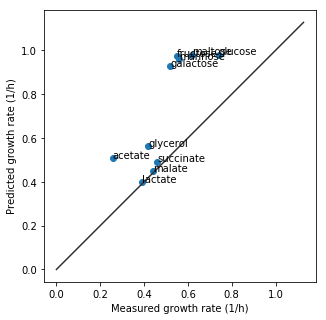

In [19]:
import scipy.stats as stats

df_val = pd.merge(df_ijo, df_Y, on='cond')
xymax = max(df_val.output.max(), df_val.muopt.max())
plt.plot([0, xymax*1.15], [0, xymax*1.15], color='#333333')
plt.scatter(df_val.output, df_val.muopt)
for i,r in df_val.iterrows():
    x = r['output']
    y = r['muopt']
    k = r['cond']
    ls = plt.text(x, y, k)
ax = ls.axes
ax.set_aspect(1)
ax.figure.set_size_inches(5,5)
ax.set_xlabel('Measured growth rate (1/h)')
ax.set_ylabel('Predicted growth rate (1/h)')

r,p = stats.pearsonr(df_val.output, df_val.muopt)
print 'Pearson r=%g (p=%g)' % (r,p)
r,p = stats.spearmanr(df_val.output, df_val.muopt)
print 'Spearman r=%g (p=%g)' % (r,p)

# Compare with ME sims

In [18]:
from dynamicme.tests.helpme import HelpME

helper = HelpME(prototyping=False)
solver = helper.solver
me = solver.me

In [19]:
import os
import ipyparallel as ipp

rc = ipp.Client()
dview = rc[:]

In [21]:
def sim_me(arg_dict):
    from dynamicme.tests.helpme import HelpME
    import time
    helper = HelpME(prototyping=False)
    solver = helper.solver
    me = solver.me
    cond = arg_dict['cond']
    df_Xk = arg_dict['df_Xk']
    for j,rowj in df_Xk.iterrows():
        rxn = me.reactions.get_by_id(rowj['rxn'])
        rxn.lower_bound = rowj['lb']
        rxn.upper_bound = rowj['ub']
        rxn.objective_coefficient = rowj['obj']
    tic = time.time()
    muopt, hs, xopt, cache = solver.bisectmu(verbosity=0, basis=solver.feas_basis)
    toc = time.time() - tic
    return {'cond':cond, 'muopt':muopt, 'time':toc}

In [22]:
import time

parargs = []
for i,row in df_Y.iterrows():
    mu_measi = row['output']
    cond = row['cond']
    df_Xk = df_conds[ df_conds.cond==cond]    
    parargs.append({'df_Xk':df_Xk, 'cond':cond})

In [29]:
sim_me(parargs[0])

{'cond': 'glucose', 'muopt': 0.826171875, 'time': 195.65168595314026}

In [24]:
me_results = dview.map_sync(sim_me, parargs)

CompositeError: one or more exceptions from call to method: sim_me
[0:apply]: UnicodeDecodeError: 'ascii' codec can't decode byte 0x83 in position 37: ordinal not in range(128)
[1:apply]: UnicodeDecodeError: 'ascii' codec can't decode byte 0x83 in position 37: ordinal not in range(128)
[2:apply]: UnicodeDecodeError: 'ascii' codec can't decode byte 0x83 in position 37: ordinal not in range(128)
[3:apply]: UnicodeDecodeError: 'ascii' codec can't decode byte 0x83 in position 37: ordinal not in range(128)
.... 3 more exceptions ...